### Notebook information

**Last updated:** 18. 10. 2023

**Authors:** ludek.cizinsky, chiara.billi, antea.ceko, irene.vardabasso, lou.houngbedji [@epfl.ch]

### Imports

In [36]:
# Modelling
from scipy.special import factorial
import statsmodels.api as sm
import scipy.stats as stats


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Define plotting style
sns.set(style="white");
sns.set_context("notebook");
sns.set_palette("muted") ;

# Data structures
import numpy as np
import pandas as pd  
import json  

# NX module(s)
from nilearn.glm.first_level.hemodynamic_models import _sample_condition
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix

# Supress some warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

### Practical part

#### Global variables

In [37]:
# NB: Time below is in seconds
TR = 2 # Repetition time, i.e., how often you obtain brain scans
stim_freq = 60 # How often we show the stimulus
stim_length = 2 # How long we show the stimulus
total_duration = 350 # How long the whole experiments lasts
amp_low, amp_high = 0.1, 2 # Lower and upper bound sampling range for the amplitude of the stimulus

#### STEP 1: Specify a fake sequence of stimuli events

<p style="color: #919090;">First, specify a fake sequence of stimuli events. To this end, create a series of presentations of faces against visual control, each individual presentation lasting 2 seconds. You are free to choose the total duration of the experiment as well as the TR for this timeseries. In other words you will have to “simulate” a time series for a single voxel.</p>

**Example**

We show the stimuli for `2s`, and this is repeated every `10s`, our TR is set to `2s` (industry standard), so then we should see the following:

`000001000001...`

In words, first `10s` there is no stimuli, thus we have 5 zeros (5 x 2 (our TR)). Then between the `10th and 12nd` there is stimuli, thus on the `6th` position we have 1. This pattern is then repetead.

**Implementation**

In [38]:
def get_stimuli(total_duration, tr, stim_time, amplitude, stim_freq):
    """
    Function that obtains timeseries of the given experiment,
    and stimuli values for TWO conditions.

    Parameters
    ----------
    total_duration : int
        Total duration of the experiment in seconds.
    tr : int
        Time repetition of the brain scan acquisition.
    stim_time: int
        How long we show the given stimuli.
    amplitude : tuple
        Tuple with lower and upper bound of the sampling range.
    stim_freq: int
        How often in seconds we show the stimuli.

    Returns
    -------
    stimuli_time : 1d array
        N = # of timepoints
    face_stimuli : 1d array
        N = # of timepoints
    object_stimuli : 1d array
        N = # of timepoints
    """

    # Define times when we are obtaining the scans of the brain using the given TR
    sample_time_points = np.array([t for t in range(total_duration) if (t % tr) == 0])

    # Define time shifts
    # For the first event, no time shift needed
    # For the second event, we do the half of the rep time --> thus important to have rep time
    # reasonable long enough.
    shifts = [0, stim_freq/2] # Define shifts

    # Collect the results
    stimuli = []
    stimuli_time = None
    amp_low, amp_high = amplitude

    for sh in shifts:

        # Define onsets of the conditions
        # E.g. stim_freq = 10, dur = 2
        # Cond1 with sh = 0: 10 - 12, 20 - 22, ...
        # Cond 2 with sh = 5: 15 - 17, 25 - 27
        onsets = np.array([t for t in range(stim_freq, total_duration) if (t % stim_freq) == 0]) + sh

        # Duration and amplitudes are arrays full of constant values
        durations = [stim_time for _ in range(len(onsets))]
        amplitudes = [np.random.uniform(amp_low, amp_high) for _ in range(len(onsets))]

        # Finally, put the above arrays to a 2d array which has 3 rows and # of columns = # of stimuli events
        stimuli_info = np.asarray([onsets, durations, amplitudes])

        # Get the stimuli values and corresponding time series
        impulse_vals, stimuli_time = _sample_condition(stimuli_info, sample_time_points, min_onset=0)
        stimuli.append(impulse_vals)

    face_stimuli, object_stimuli = stimuli

    return stimuli_time, face_stimuli, object_stimuli

**Test the implementation out**

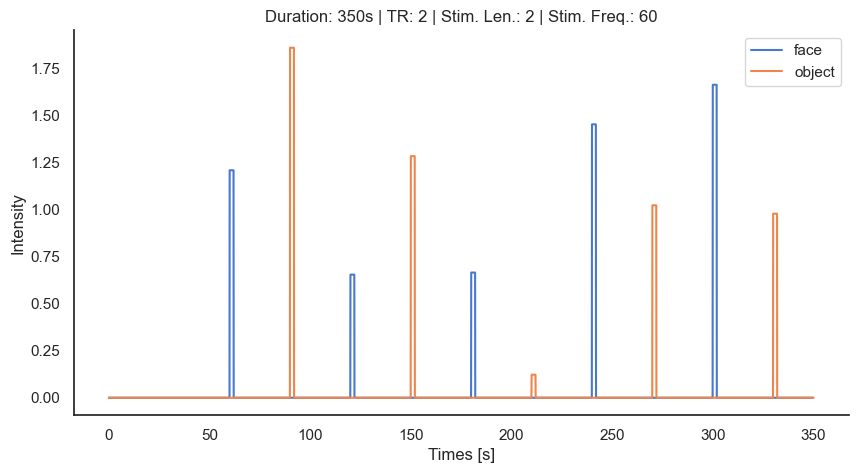

In [39]:
# Obtain timeseries and corresponding stimuli values
stimuli_time, face_stimuli, object_stimuli = get_stimuli(total_duration, TR, stim_length, (amp_low, amp_high,), stim_freq)

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=stimuli_time, y=face_stimuli, label='face', ax=ax)
sns.lineplot(x=stimuli_time, y=object_stimuli, label='object', ax=ax)
ax.set_xlabel('Times [s]')
ax.set_ylabel('Intensity')
ax.set_title(f'Duration: {total_duration}s | TR: {TR} | Stim. Len.: {stim_length} | Stim. Freq.: {stim_freq}')
ax.legend();
sns.despine();

# Save the plot
plt.savefig("figures/1 - Stimuli.png")

#### STEP 2: Define HRF function and the Convolve

<p style="color: #919090;">
The brain has a delayed hemodynamic response to events that have a particular shape, so we will need to convolve these events with an appropriate HRF function. Code the definition of the HRF function using the expression below based on the double-gamma definition (seen in class). Convolve the time course with the HRF function [1].
</p>

$$
h(t)=A\left(\frac{t^{\alpha_1-1} \beta_1^{\alpha_1} e^{-\beta_1 t}}{\Gamma\left(\alpha_1\right)}-c \frac{t^{\alpha_2-1} \beta_2^{\alpha_2} e^{-\beta_2 t}}{\Gamma\left(\alpha_2\right)}\right)
$$

<p style="color: #919090;">
With Default params:
</p>

$$
\alpha_1=6, \alpha_2=16, \beta_1=\beta_2=1 \text { and } c=1 \%
$$

<p style="color: #919090;">
A is the amplitude of the HRF (which in the case of the GLM is what you try to recover through model fitting!). You can use both the mathematical definition above or the library scipy.stats to generate the probability density function of the gamma distribution.
</p>

**Implementation of HRF**

In [40]:
def hrf(t, a1=6, a2=16, c=1/6):
    return (stats.gamma.pdf(t,a1) - c*stats.gamma.pdf(t,a2))

**Convolution**

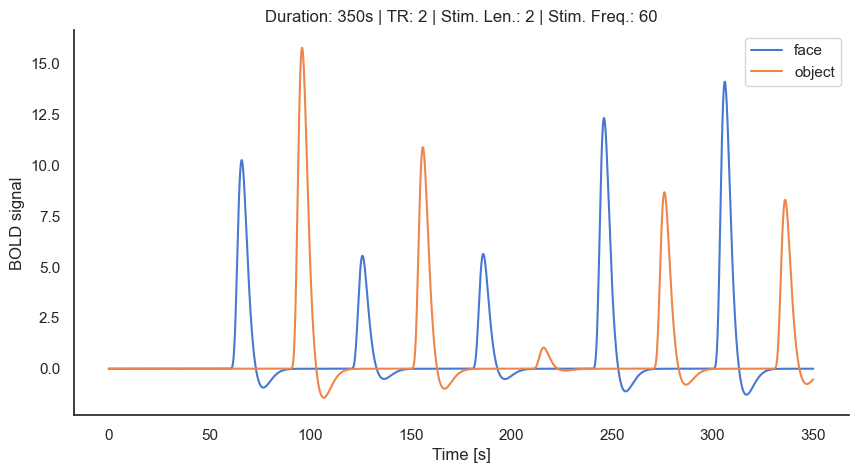

In [41]:
# Compute the values of the HRF function 
hrf_values = hrf(stimuli_time) 

# Convolve event sequence with the HRF
simulated_bold_face = np.convolve(face_stimuli, hrf_values, mode='full')[:len(hrf_values)]
simulated_bold_object = np.convolve(object_stimuli, hrf_values, mode='full')[:len(hrf_values)]

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=stimuli_time, y=simulated_bold_face, label='face', ax=ax)
sns.lineplot(x=stimuli_time, y=simulated_bold_object, label='object', ax=ax)
ax.set_title(f'Duration: {total_duration}s | TR: {TR} | Stim. Len.: {stim_length} | Stim. Freq.: {stim_freq}')
ax.set_xlabel('Time [s]');
ax.set_ylabel('BOLD signal');
sns.despine()
ax.legend();

# Save the plot
plt.savefig("figures/2 - Convoluted stimuli.png")

> STEP 3: Change the HRF function parameters

<p style="color: #919090;"> Change the HRF function parameters (α1 and  α2) of the gamma distributions to obtain slightly different shapes and perform comparisons.
</p>

**Implementation**

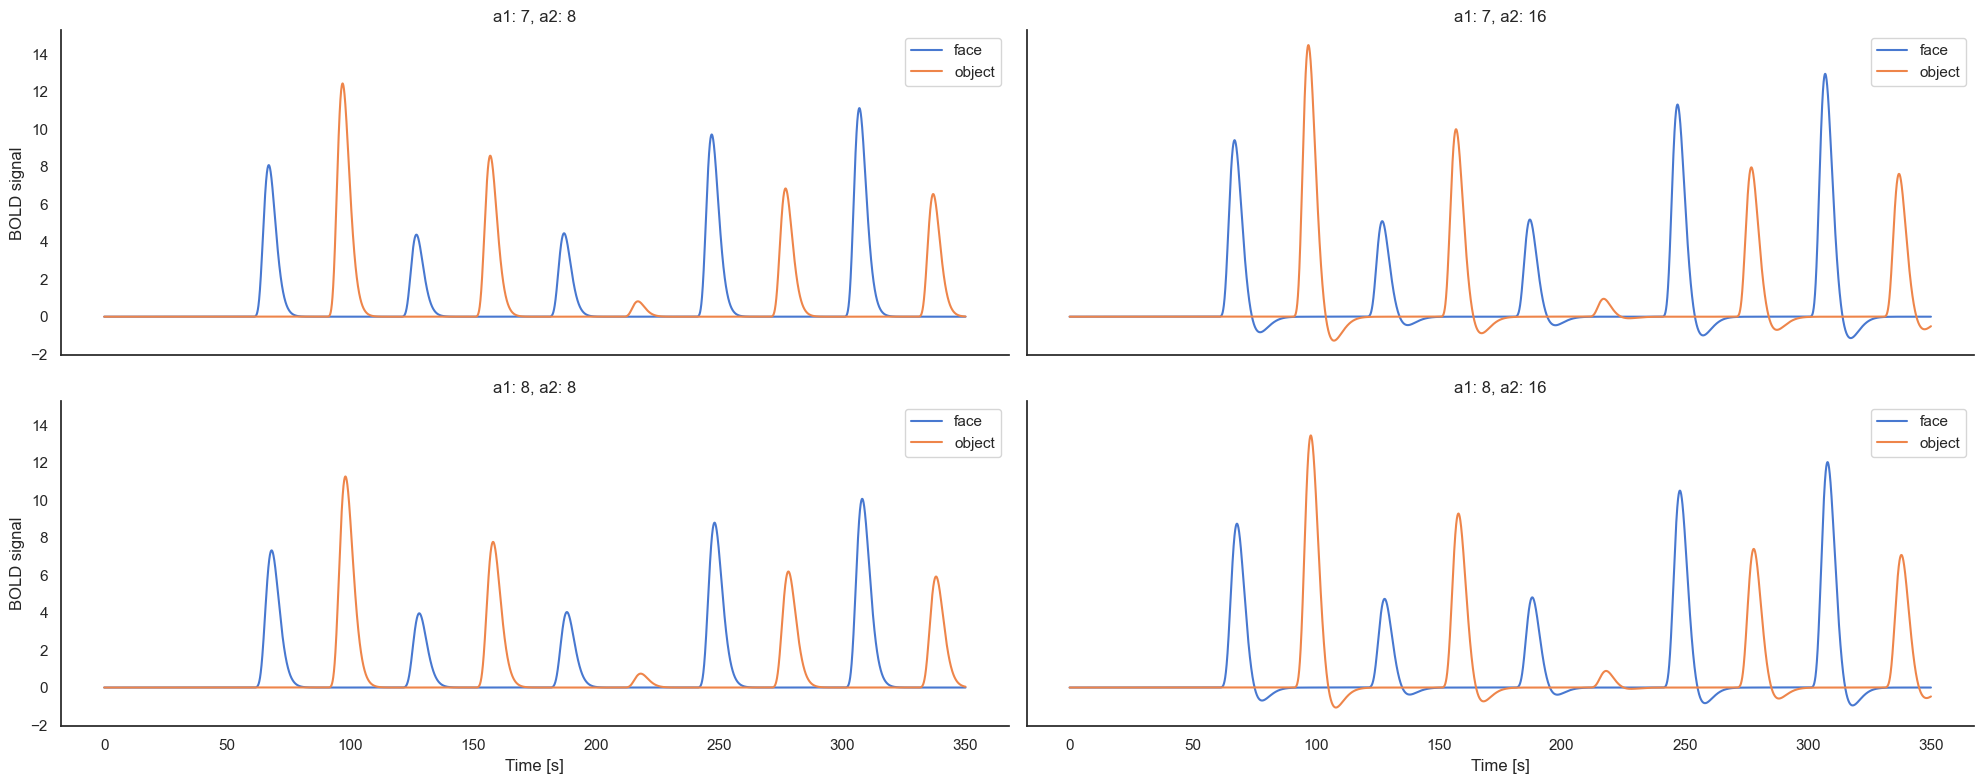

In [42]:
num_row = 2
num_col = 2
fig, axs = plt.subplots(num_row, num_col, figsize=(20, 8), sharex=True, sharey=True)
a1_list = [7, 8]
a2_list = [8, 16]

for ind_1, a1_value in enumerate(a1_list):
    for ind_2, a2_value in enumerate(a2_list):

        # Get the data
        hrf_values = hrf(stimuli_time, a1_value, a2_value)
        simulated_bold_face = np.convolve(face_stimuli, hrf_values, mode='full')[:len(hrf_values)]
        simulated_bold_object = np.convolve(object_stimuli, hrf_values, mode='full')[:len(hrf_values)]

        # Plot the data
        ax = axs[ind_1][ind_2]
        sns.lineplot(x=stimuli_time, y=simulated_bold_face, label='face', ax=ax)
        sns.lineplot(x=stimuli_time, y=simulated_bold_object, label='object', ax=ax)
        ax.set_title(f"a1: {a1_value}, a2: {a2_value}")
        ax.set_xlabel('Time [s]');
        ax.set_ylabel('BOLD signal');
        sns.despine()
        ax.legend();

plt.tight_layout()

# Save the plot
plt.savefig("figures/step3_choosing_alphas.png")

**Our choice and reasoning**

We decided to go with a1=8 and a2=16 since the corresponding plot is the one the shows in the most realistic way the main features of a bold response in terms of initial dip, peak and undershoot.

#### STEP 4: Choose any HRF model and add Gaussian noise with a sigma of 0.15

<p style="color: #919090;">In reality, the data is much noisier and the noise comes from low-frequency drift, autocorrelation, or possibly some aliased physiological artefacts. Choose any HRF model and add Gaussian noise with a sigma of 0.15. The goal of this part is to generate simulated activity from a voxel.
</p>

**Implementation**

In [43]:
# Generate the bold signal with chosen parameters
# - Params
a1, a2 = 8, 16

# - Generate the data
hrf_values = hrf(stimuli_time, a1, a2)
simulated_bold_face_fin = np.convolve(face_stimuli, hrf_values, mode='full')[:len(hrf_values)]
simulated_bold_object_fin = np.convolve(object_stimuli, hrf_values, mode='full')[:len(hrf_values)]

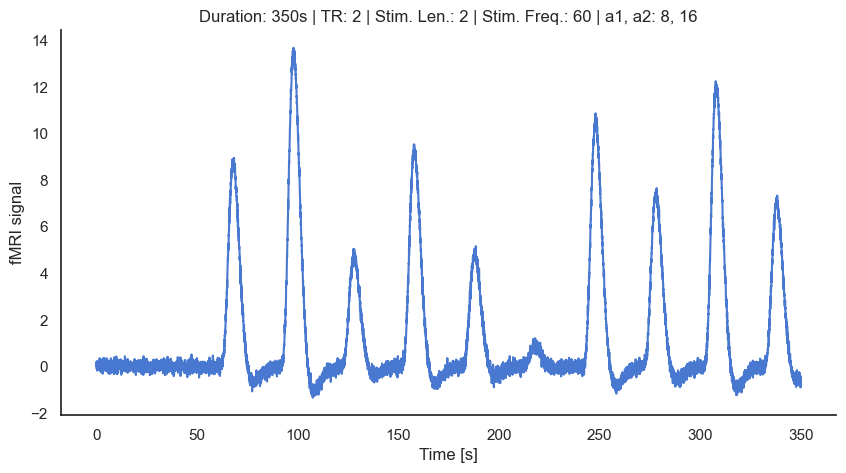

In [44]:
# Generate the noise
noise_mean, noise_std = 0, 0.15
gaussian_noise = np.random.normal(noise_mean, noise_std, len(stimuli_time))

# Combine the signal from the individual conditions and then add noise
y = simulated_bold_face_fin + simulated_bold_object_fin + gaussian_noise

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=stimuli_time, y=y, ax=ax)
ax.set_title(f'Duration: {total_duration}s | TR: {TR} | Stim. Len.: {stim_length} | Stim. Freq.: {stim_freq} | a1, a2: {a1}, {a2}')
ax.set_xlabel('Time [s]');
ax.set_ylabel('fMRI signal');
sns.despine();

# Save the plot
plt.savefig(f"figures/4 - Noise.png")

#### STEP 5 & 6: model fitting

<p style="color: #919090;">Recover the original signal using a general linear model in the form of: 𝑌 = 𝑋β + ϵ , where 𝑌 is our observed voxel time series, 𝑋 is our model or design matrix, and is where we will specify a predicte response to each condition. β is a vector of values that we will estimate to scale our model and ϵ is independent Gaussian noise. Build a design matrix 𝑋 using an intercept, and a regressor indicating the onset of each condition, convolved with the hemodynamic response function (HRF). Quantify the degree to which your model is accurately predicting the observed data by calculating the residual 𝑟𝑒𝑠𝑖𝑑𝑢𝑎𝑙 = 𝑌 − 𝑌_hat.
</p>

**Implementation - model fitting**

In [45]:
# Define design matrix
X = np.vstack((simulated_bold_face_fin, simulated_bold_object_fin)).T
X = sm.add_constant(X) # the constant will be the first column 

# Define the model
# f(x)= X_face * b_face + X_object*b_object + 1*b0
model = sm.OLS(y,X)

# Fit the model
results = model.fit()

In [46]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.629e+06
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        13:58:16   Log-Likelihood:                 4271.4
No. Observations:                8751   AIC:                            -8537.
Df Residuals:                    8748   BIC:                            -8516.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.156      0.876      -0.003       0.004
x1             1.0001      0.001   1335.357      0.000       0.999       1.002
x2             0.9996      0.001   1333.808      0.000       0.998       1.001
==============================================================================
Omnibus:                        5.047   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.057
Skew:                           0.047   Prob(JB):                       0.0798
Kurtosis:                       3.070   Cond. No.                         2.55
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Implementation - how well our model fits the data**

In [47]:
# Obtain predicted values and residuals
yhat = results.fittedvalues
residuals = results.resid

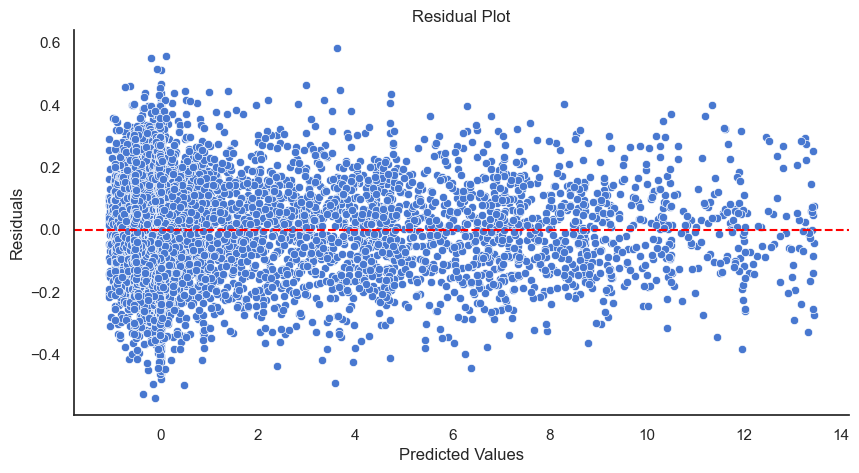

In [48]:
# Show residual plot - if good fit, the points should be randomly scattered.
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=yhat, y=residuals, ax=ax)
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Residuals")
ax.set_title("Residual Plot")
plt.axhline(y=0, color='red', linestyle='--');  # Add a horizontal line at y=0
sns.despine()

# Save the plot
plt.savefig("figures/6 - Residual plot.png");

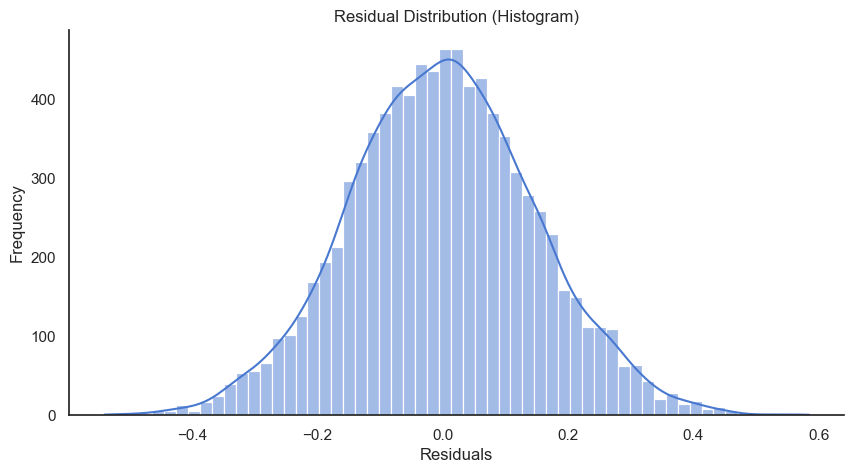

In [49]:
# Show histogram - should resemble normal distribution
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(residuals, kde=True, ax=ax)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
ax.set_title("Residual Distribution (Histogram)")
sns.despine()

# Save the plot
plt.savefig("figures/7 - Residual distribution.png");


#### STEP 7: is any of the regressors statistically significant?

<p style="color: #919090;">Perform a hypothesis test to evaluate if any of the regressors are statistically different from zero.
</p>

**P-value computation**

In [50]:
# Define contrasts vectors based on for which condition we want to test
cs = [
    ('face', [0, 1, 0]),
    ('object', [0, 0, 1])
]

# Extract the needed parameters
B = np.array(results.params).reshape(-1, 1)
e = gaussian_noise.reshape(-1, 1)
N_T = len(stimuli_time)
P = X.shape[1]
dof = N_T - P # degrees of freedom
a = 0.05 # Set the significance threshold

for condition, c in cs:

    print(f'Testing: {condition}')
    # Convert c to column vector
    c = np.array(c).reshape(-1, 1)

    # Compute the test statistic
    numerator = (c.T @ B)[0, 0] # Gives 1 x 1 matrix, thus need the indexing
    var = (e.T @ e)[0, 0] / (N_T - P)
    tmp = (c.T @ np.linalg.inv(X.T @ X) @ c)[0, 0]
    denominator = np.sqrt(var * tmp)
    that = numerator / denominator

    # Compute the one sided p-value
    p_value = 1 - stats.t.cdf(that, df=dof)
    print(f'that is: {round(that, 2)}, p-value is: {p_value}')
    is_significant = '' if p_value < a else 'not'
    print(f'Thus, given alpha = {a}, the regressor is {is_significant} statistically signifficant.\n')

Testing: face
that is: 1335.34, p-value is: 0.0
Thus, given alpha = 0.05, the regressor is  statistically signifficant.

Testing: object
that is: 1333.79, p-value is: 0.0
Thus, given alpha = 0.05, the regressor is  statistically signifficant.



#### Step 8: Graphical representation of design matrix

<p style="color: #919090;">Show a graphical representation of the design matrix and the contrast between the face and object condition</p>

**Show design matrix**

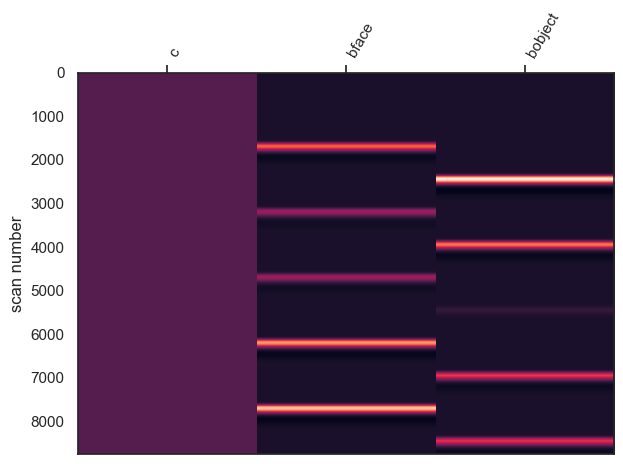

In [51]:
X_df = pd.DataFrame(X, columns=['c', 'bface', 'bobject'])
fig, ax = plt.subplots();
plot_design_matrix(X_df, ax=ax);
plt.savefig("figures/8 - Design Matrix.png");

**Show contrast between face and object condition**

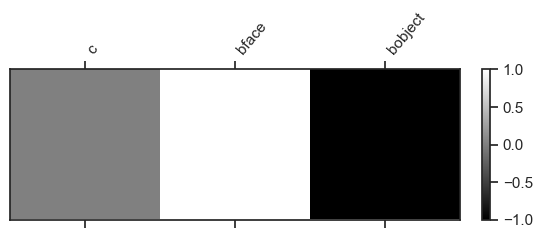

In [52]:
fig, ax = plt.subplots();
c = np.array([0, 1, -1]) # Difference between face and object
plot_contrast_matrix(c, X_df, colorbar=True, ax=ax);
plt.savefig("figures/9 - Conreast.png");

#### Bonus STEP 9: Repeat the practical steps 1-6) using the dataset that is accessible through openneuroi

<p style="color: #919090;">BONUS: Repeat the practical steps 1-6) using the dataset that is accessible through openneuroi: https://openneuro.org/datasets/ds000105/versions/00001. You could select one subject and download one of the .tsv file.</p>

In order to perform steps 1-6 on a real experimental setting, we chose the file from `run 08` on `subject 2`, from theOpenfMRI project.

In [53]:
# Load TR from the metadata file
with open('data/s02_r08/metadata.json') as f:
    metadata = json.load(f)
    TR_exp = float(metadata['RepetitionTime'])

# Load the events data
df_exp = pd.read_csv('data/s02_r08/events.tsv', sep='\t')

# Show the sample of data
print(f"Experiment TR was: {TR_exp} and the events data looks as follows:")
df_exp.head()

Experiment TR was: 2.5 and the events data looks as follows:


,onset,duration,trial_type
0,12.0,0.5,face
1,14.0,0.5,face
2,16.0,0.5,face
3,18.0,0.5,face
4,20.0,0.5,face


We first encode the events as 1D numpy arrays representin the time series given the `TR`, `onset` and `duration` of the event. 

In [54]:
# Get unique events
events = df_exp['trial_type'].unique()

# Show them
list(events)

['face', 'chair', 'scissors', 'shoe', 'scrambledpix', 'house', 'cat', 'bottle']

In [55]:
amp_lower, amp_upper = .2, 2

In [56]:
# Obtain sample time points based on the x
total_duration_exp = int(df_exp['onset'].max() + 10) # 10s as a buffer
sample_time_points_exp = np.array([t for t in range(total_duration_exp) if (t % TR_exp) == 0])

# Conditions samples
condition_samples = dict()

for i in range(len(events)):
    # Get the event type
    event = events[i]

    # Get the event's onset and duration and use it to create stimuli info
    event_mask = df_exp['trial_type'] == event
    onsets, durations = list(df_exp[event_mask]['onset']), list(df_exp[event_mask]['duration'])
    amplitudes = [np.random.uniform(amp_lower, amp_upper) for _ in range(len(onsets))]
    stimuli_info_exp = np.asarray([onsets, durations, amplitudes])

    # Sample the condition
    impulse_vals, stimuli_time = _sample_condition(stimuli_info_exp, sample_time_points_exp, min_onset=0)

    # Save the result
    condition_samples[event] = impulse_vals

# Save the final result as pandas df for easier processing later on
condition_samples['stimuli_time'] = stimuli_time # This is same for all events indeed
samples_df = pd.DataFrame(condition_samples)

Now, let's check the samples via visualization:

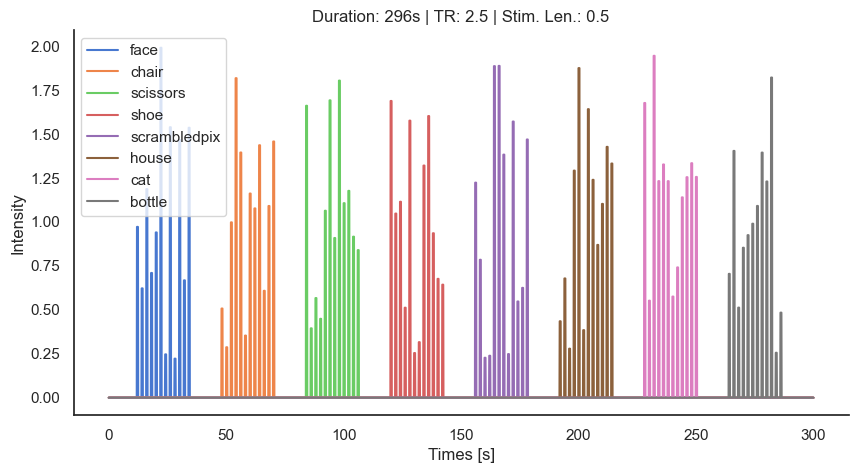

In [57]:
# Setup the figure
fig, ax = plt.subplots(figsize=(10, 5))

for i in range(len(events)):
    event = events[i] # name of the event (str)
    sns.lineplot(data=samples_df, x='stimuli_time', y=event, label=event, ax=ax)
    ax.set_xlabel('Times [s]')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Duration: {total_duration_exp}s | TR: {TR_exp} | Stim. Len.: 0.5')

# Add legend and get rid of some figure borders (despine)
ax.legend();
sns.despine();

# Save the plot
plt.savefig("figures/exp_stimuli_series.png")

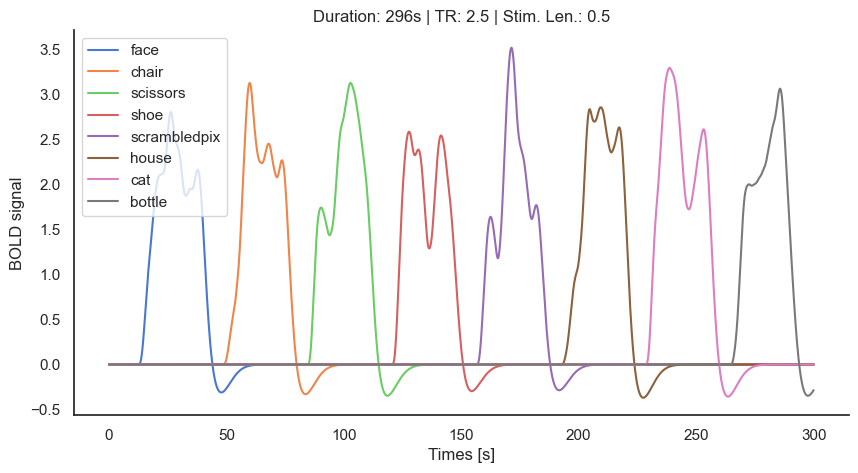

In [58]:
# Compute the values of the HRF function 
hrf_values_exp = hrf(samples_df['stimuli_time']) 

# Convolve each event sequence with the HRF and plot it
simulated_bold_exp = dict()
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(len(events)):
    event = events[i] # name of the event (str)
    simulated_bold_exp[event] = np.convolve(samples_df[event], hrf_values_exp, mode='full')[:len(hrf_values_exp)]
    sns.lineplot(x=samples_df['stimuli_time'], y=simulated_bold_exp[event], label=event, ax=ax)
    ax.set_xlabel('Times [s]')
    ax.set_ylabel('BOLD signal')
    ax.set_title(f'Duration: {total_duration_exp}s | TR: {TR_exp} | Stim. Len.: 0.5')

# Add legend and get rid of some figure borders (despine)
sns.despine()
ax.legend();

# Save the plot
plt.savefig("figures/exp_stimuli_bold.png")


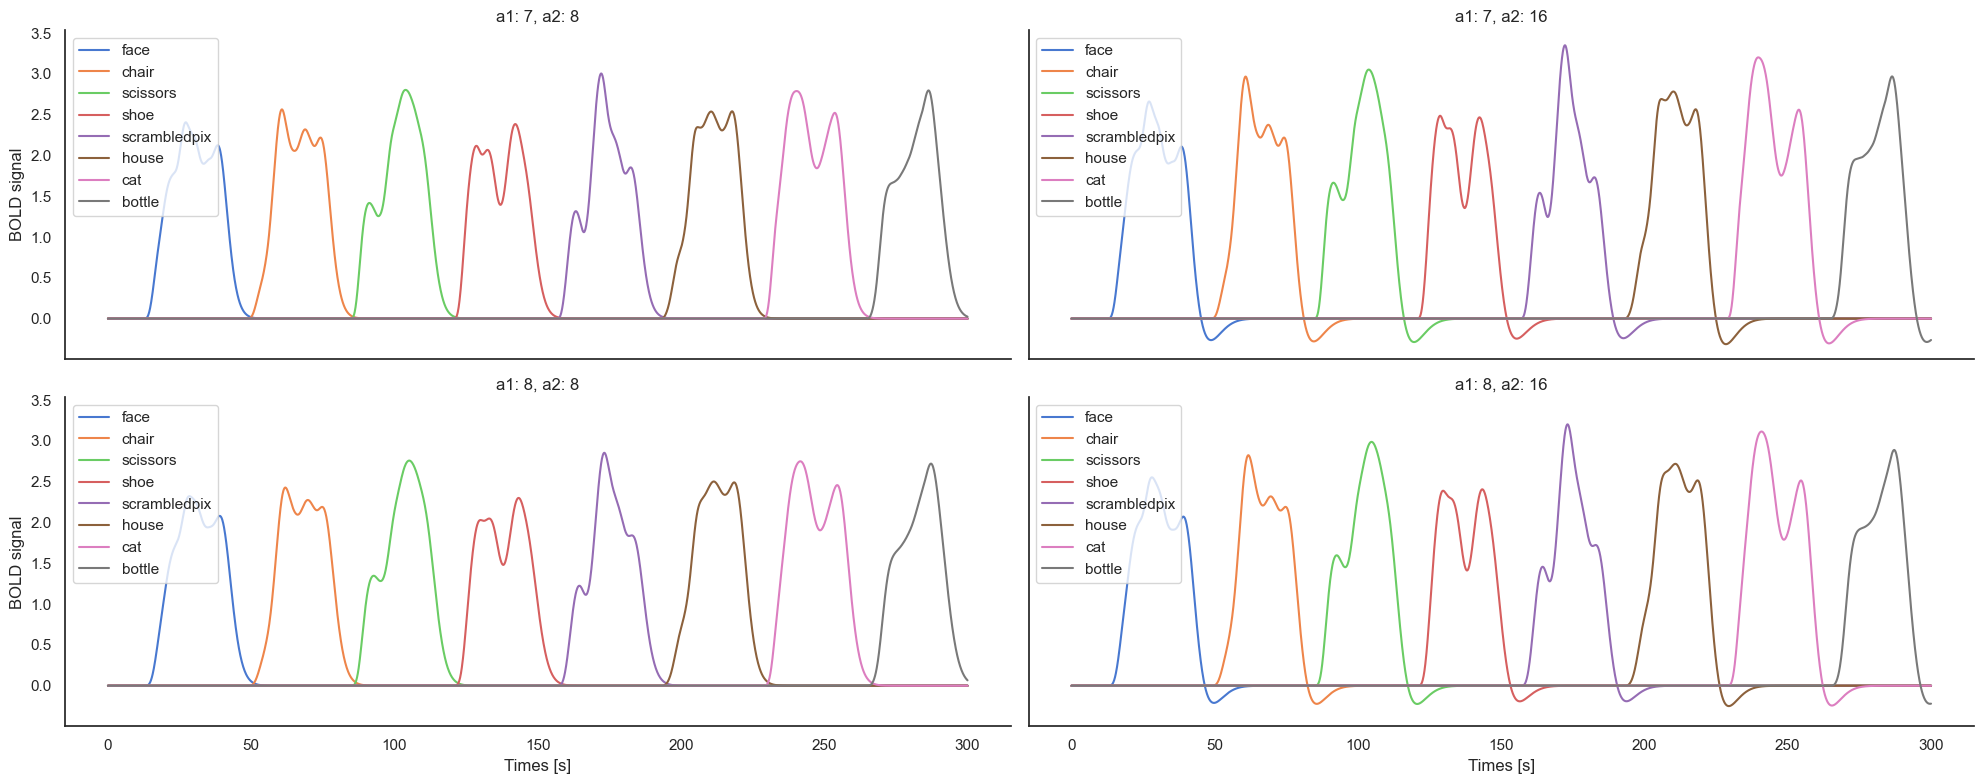

In [59]:
# Changing the HRF function parameters 
num_row = 2
num_col = 2
fig, axs = plt.subplots(num_row, num_col, figsize=(20, 8), sharex=True, sharey=True)
a1_list = [7, 8]
a2_list = [8, 16]

for ind_1, a1_value in enumerate(a1_list):
    for ind_2, a2_value in enumerate(a2_list):

        # Get the data
        hrf_values_exp = hrf(samples_df['stimuli_time'], a1_value, a2_value) 
        for i in range(len(events)):
            event = events[i] # name of the event (str)
            simulated_bold_exp[event] = np.convolve(samples_df[event], hrf_values_exp, mode='full')[:len(hrf_values_exp)]
            ax = axs[ind_1][ind_2]
            sns.lineplot(x=samples_df['stimuli_time'], y=simulated_bold_exp[event], label=event, ax=ax)
        ax.set_xlabel('Times [s]')
        ax.set_ylabel('BOLD signal')
        ax.set_title(f"a1: {a1_value}, a2: {a2_value}")
        sns.despine()
        ax.legend();

plt.tight_layout()

# Save the plot
plt.savefig("figures/exp_choosing_alpha.png")

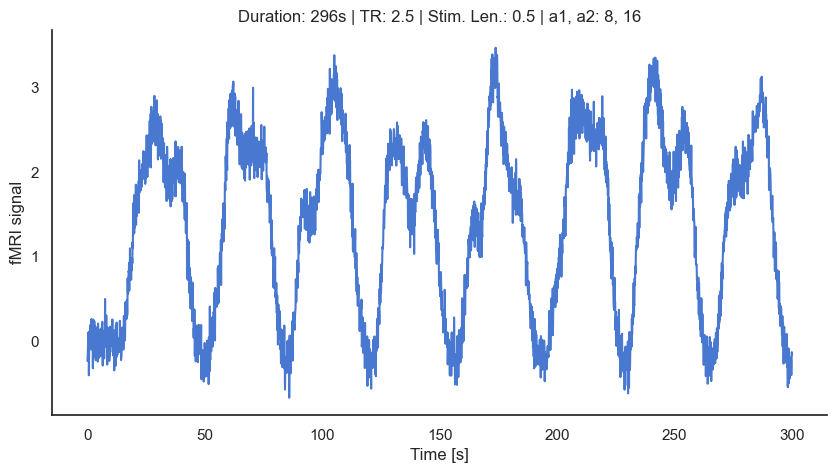

In [60]:
# Generate the bold signal with chosen parameters
# - Params
a1, a2 = 8, 16

# - Generate the data
hrf_values_exp = hrf(samples_df['stimuli_time'], a1, a2)
bold_sum = np.zeros((len(hrf_values_exp)))
for i in range(len(events)):
    event = events[i] # name of the event (str)
    simulated_bold_exp[event] = np.convolve(samples_df[event], hrf_values_exp, mode='full')[:len(hrf_values_exp)]
    bold_sum += simulated_bold_exp[event]

# Save the final result as pandas df for easier processing later on
simulated_bold_exp['stimuli_time'] = samples_df['stimuli_time']# This is same for all events indeed
bold_exp_df = pd.DataFrame(simulated_bold_exp)

# Generate the noise
noise_mean, noise_std = 0, 0.15
gaussian_noise = np.random.normal(noise_mean, noise_std, len(bold_exp_df['stimuli_time']))

# Combine the signal from the individual conditions and then add noise
y_exp = bold_sum + gaussian_noise

# Plot the data
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=bold_exp_df['stimuli_time'], y=y_exp, ax=ax)
ax.set_title(f'Duration: {total_duration_exp}s | TR: {TR_exp} | Stim. Len.: 0.5 | a1, a2: {a1}, {a2}')
ax.set_xlabel('Time [s]');
ax.set_ylabel('fMRI signal');
sns.despine();

# Save the plot
plt.savefig(f"figures/exp_fMRI_signal.png")


In [61]:
# Define design matrix
X_exp = np.ones([1,len(hrf_values_exp)])
for i in range(len(events)):
    event = events[i]
    X_exp = np.vstack((X_exp, simulated_bold_exp[event]))
X_exp = X_exp.T

# Define the model
# f(x)= X_face * b_face + X_object*b_object + 1*b0
model_exp = sm.OLS(y_exp,X_exp)

# Fit the model
results_exp = model_exp.fit()
results_exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.729e+04
Date:                Wed, 18 Oct 2023   Prob (F-statistic):               0.00
Time:                        13:58:26   Log-Likelihood:                 1368.9
No. Observations:                3001   AIC:                            -2720.
Df Residuals:                    2992   BIC:                            -2666.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.005     -0.981      0.327      -0.014       0.005
x1             1.0030      0.005    188.130      0.000       0.993       1.013
x2             1.0030      0.005    197.414      0.000       0.993       1.013
x3             1.0074      0.005    203.742      0.000       0.998       1.017
x4             0.9901      0.005    181.781      0.000       0.979       1.001
x5             1.0050      0.005    194.341      0.000       0.995       1.015
x6             0.9968      0.005    204.559      0.000       0.987       1.006
x7             1.0034      0.005    221.687      0.000       0.995       1.012
x8             0.9880      0.005    190.103      0.000       0.978       0.998
==============================================================================
Omnibus:                        0.840   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.657   Jarque-Bera (JB):                0.890
Skew:                           0.034   Prob(JB):                        0.641
Kurtosis:                       2.951   Cond. No.                         3.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

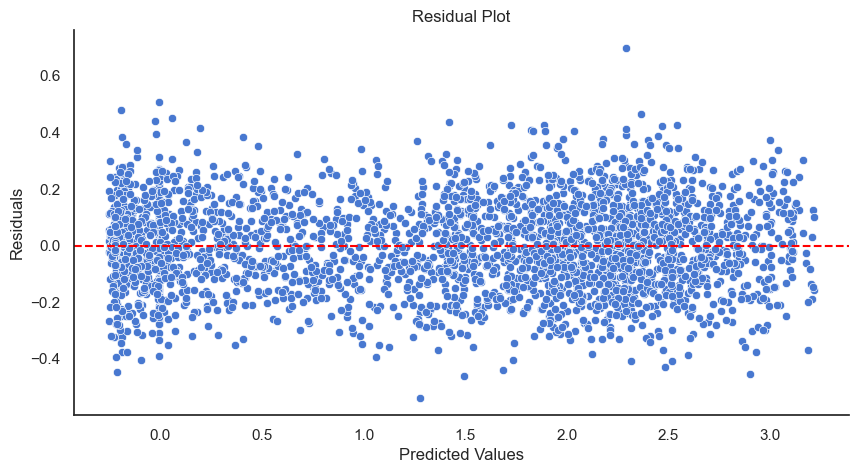

In [62]:
# Obtain predicted values and residuals
yhat_exp = results_exp.fittedvalues
residuals_exp = results_exp.resid

# Show residual plot - if good fit, the points should be randomly scattered.
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=yhat_exp, y=residuals_exp, ax=ax)
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Residuals")
ax.set_title("Residual Plot")
plt.axhline(y=0, color='red', linestyle='--');  # Add a horizontal line at y=0
sns.despine()

# Save the plot
plt.savefig("figures/exp_residual_plot");

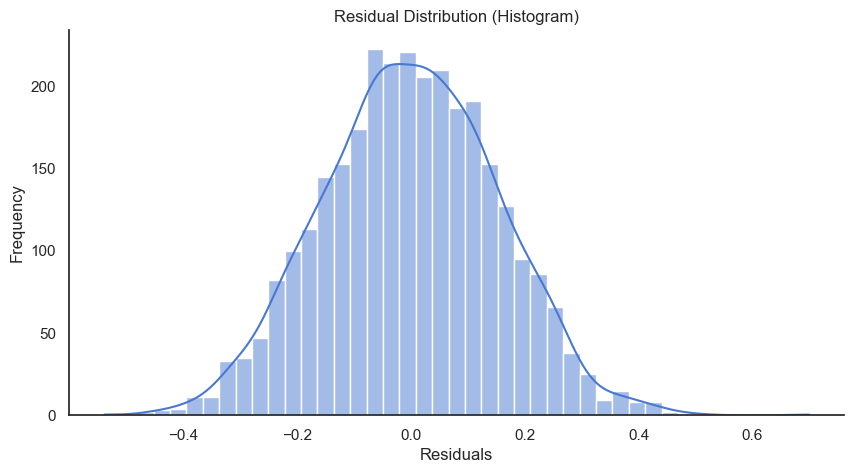

In [63]:
# Show histogram - should resemble normal distribution
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(residuals_exp, kde=True, ax=ax)
ax.set_xlabel("Residuals")
ax.set_ylabel("Frequency")
ax.set_title("Residual Distribution (Histogram)")
sns.despine()

# Save the plot
plt.savefig("figures/exp_residuals_hist");


---